In [ ]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = "../data"

In [19]:
dfs = [
    (
        "Llama 2",
        "Vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2021_llama-awq_rephrase_vript.pkl"),
    ),
    (
        "Llama 2",
        "FineNews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2032_llama-awq_rephrase_finenews.pkl"),
    ),
    (
        "Llama 2",
        "Common Corpus",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2067_llama-awq_rephrase_commoncorpus.pkl"),
    ),
    (
        "PolyLM 4bit",
        "Vript",
        pd.read_pickle(f"{data_dir}/full/multiling_results_2033_polylm-1.7b_4bit_rephrase_vript.pkl"),
    ),
    (
        "PolyLM 4bit",
        "FineNews",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1981_polylm-1.7b_4bit_rephrase_commoncorpus.pkl"),
    ),
    (
        "PolyLM 4bit",
        "Common Corpus",
        pd.read_pickle(f"{data_dir}/full/multiling_results_1982_polylm-1.7b_4bit_rephrase_finenews.pkl"),
    ),
]

In [20]:
llama_language_percentages = {
    "en": 0.897,
    "de": 0.0017,
    "es": 0.0013,
    "fr": 0.0016,
    "it": 0.0011,
    "ko": 0.0006,
    "pt": 0.0009,
    "ru": 0.0013,
    "zh": 0.0013,
}

polylm_language_percentages = {
    "en": 0.897,
    "de": 0.0017,
    "es": 0.0089,
    "fr": 0.0081,
    "it": 0.0069,
    "ko": 0.0013,
    "pt": 0.0068,
    "ru": 0.0121,
    "zh": 0.2214,
}

In [21]:
for model, dataset, df in dfs:
    if "llama" in model.lower():
        df["language_share"] = df["language"].map(llama_language_percentages)
    elif "polylm" in model.lower():
        df["language_share"] = df["language"].map(polylm_language_percentages)

    df["model"] = model
    df["dataset"] = dataset

    df["rephrased_gradient_mean"] = df["rephrased_gradients"].apply(
        lambda x: np.mean(x)
    )

    df["total_gradient"] = df["prompt_gradient"] + df["rephrased_gradient_mean"]

    df["total_gradient_std"] = df.apply(
        lambda x: np.std(x["rephrased_gradients"] + [x["prompt_gradient"]]), axis=1
    )

df_all = pd.concat([df for _, __, df in dfs])
dfs.append(("All", "All", df_all))

In [47]:
metric_alias = {
    'prompt_gradient': 'Identity',
    'rephrased_gradient_mean': 'Rephrase',
    'rephrased_gradient_std': 'Rephrase Std',
}

def plot_multiling(
    dfs,
    log_x_axis=True,
    log_y_axis=True,
    output_base="../figures/multiling",
):
    os.makedirs(output_base, exist_ok=True)
    plt.rcParams["figure.dpi"] = 120
    plot_size = 4
    n_models = len(dfs)
    n_rows = 9

    fig_grid, axs = plt.subplots(
        n_rows,
        n_models,
        figsize=(plot_size * n_models, plot_size * n_rows),
        squeeze=False,
        constrained_layout=True,
    )

    subplot_specs = [
        ("line", "prompt_gradient"),
        ("box",  "prompt_gradient"),
        ("reg",  "prompt_gradient"),
        ("line", "rephrased_gradient_mean"),
        ("box",  "rephrased_gradient_mean"),
        ("reg",  "rephrased_gradient_mean"),
        ("line", "rephrased_gradient_std"),
        ("box",  "rephrased_gradient_std"),
        ("reg",  "rephrased_gradient_std"),
    ]

    for col_idx, (model, dataset, df) in enumerate(dfs):
        out_dir = os.path.join(output_base, dataset, model)
        os.makedirs(out_dir, exist_ok=True)
        legend_flag = (model == "All")

        for row_idx, (kind, metric) in enumerate(subplot_specs):
            fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)

            if kind == "line":
                sns.lineplot(
                    data=df, x="language_share", y=metric,
                    hue="model", legend=False, ax=ax
                )
            elif kind == "box":
                sns.boxplot(
                    data=df, x="language_share", y=metric,
                    hue="model", legend=False, ax=ax
                )
            else:
                sns.regplot(
                    data=df, x="language_share", y=metric,
                    scatter=True, ax=ax
                )

            if log_x_axis:
                ax.set_xscale("log")
            if kind in ("line", "reg") and log_y_axis:
                ax.set_yscale("log")

            grid_ax = axs[row_idx][col_idx]
            if kind == "line":
                sns.lineplot(
                    data=df, x="language_share", y=metric,
                    hue="model", legend=legend_flag, ax=grid_ax
                )
            elif kind == "box":
                sns.boxplot(
                    data=df, x="language_share", y=metric,
                    hue="model", legend=legend_flag, ax=grid_ax
                )
            else:
                sns.regplot(
                    data=df, x="language_share", y=metric,
                    scatter=True, ax=grid_ax
                )

            if log_x_axis:
                grid_ax.set_xscale("log")
            if kind in ("line", "reg") and log_y_axis:
                grid_ax.set_yscale("log")

            ax.set_xlabel("")
            ax.set_ylabel("")
            if ax.get_legend():
                ax.legend_.remove()

            grid_ax.set_title(f"{dataset} - {model}")
            grid_ax.set_xlabel("Language share")
            grid_ax.set_ylabel(metric_alias[metric])
            grid_ax.tick_params(axis="x", labelrotation=90)

            filename = f"{metric}_{kind}.png"
            fig.savefig(os.path.join(out_dir, filename), transparent=True, dpi=300)
            plt.close(fig)

    plt.show()


def compute_gradient_regressions(dfs):
    for model, dataset, df in dfs:
        reg_df = df.copy()
        reg_df['log_language_share'] = np.log(reg_df['language_share'] + 1e-9)

        print(f"Regression results for {dataset} - {model}:")
        for metric in [
            'prompt_gradient',
            'rephrased_gradient_mean',
            'rephrased_gradient_std',
        ]:
            result = smf.ols(
                f"{metric} ~ log_language_share", data=reg_df
            ).fit()
            coef = result.params['log_language_share']
            stderr = result.bse['log_language_share']
            pval = result.pvalues['log_language_share']
            print(
                f"  {metric_alias[metric]:>12}: coef = {coef:>8.4f}, "
                f"SE = {stderr:>6.4f}, p = {pval:.4f}"
            )
        print()


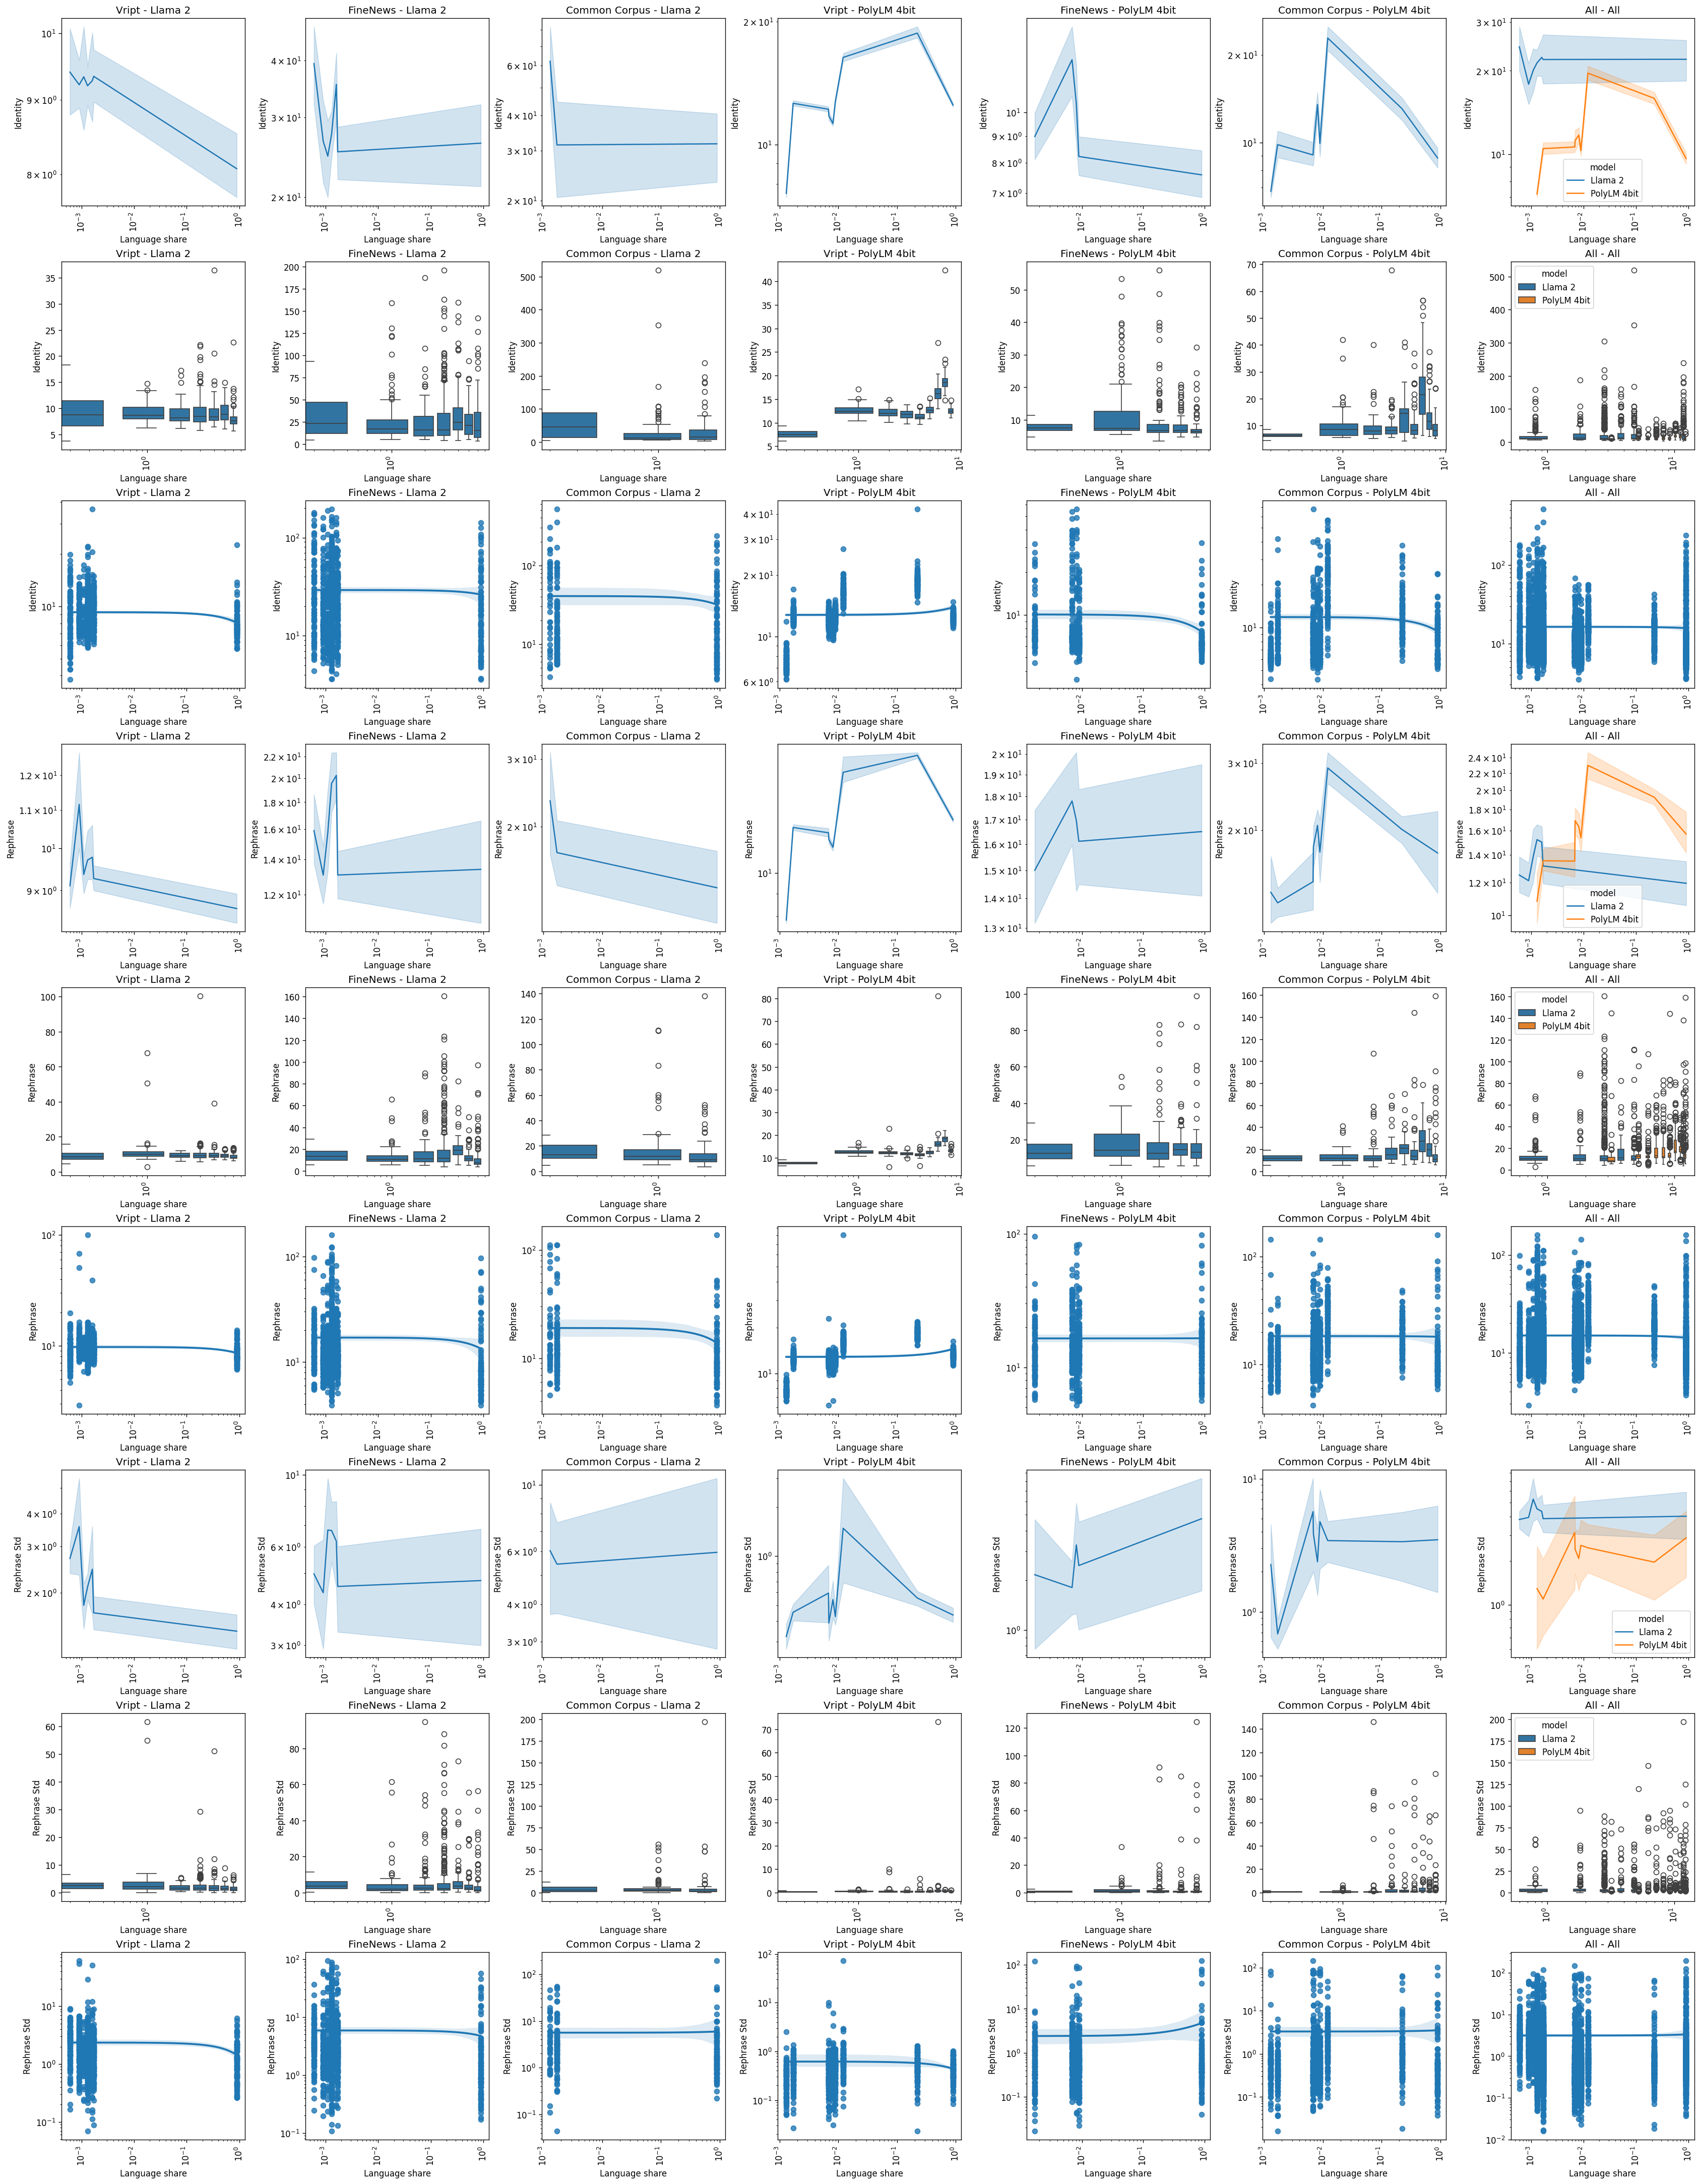

In [48]:
plot_multiling(dfs)

In [49]:
compute_gradient_regressions(dfs)

Regression results for Vript - Llama 2:
      Identity: coef =  -0.1785, SE = 0.0419, p = 0.0000
      Rephrase: coef =  -0.1733, SE = 0.0727, p = 0.0173
  Rephrase Std: coef =  -0.1581, SE = 0.0591, p = 0.0076

Regression results for FineNews - Llama 2:
      Identity: coef =  -0.5814, SE = 0.4621, p = 0.2086
      Rephrase: coef =  -0.4880, SE = 0.2546, p = 0.0556
  Rephrase Std: coef =  -0.1483, SE = 0.1696, p = 0.3821

Regression results for Common Corpus - Llama 2:
      Identity: coef =  -1.5347, SE = 1.1998, p = 0.2021
      Rephrase: coef =  -0.8362, SE = 0.3941, p = 0.0349
  Rephrase Std: coef =   0.0505, SE = 0.3185, p = 0.8743

Regression results for Vript - PolyLM 4bit:
      Identity: coef =   0.7974, SE = 0.0485, p = 0.0000
      Rephrase: coef =   0.8251, SE = 0.0578, p = 0.0000
  Rephrase Std: coef =   0.0058, SE = 0.0429, p = 0.8922

Regression results for FineNews - PolyLM 4bit:
      Identity: coef =  -0.3965, SE = 0.1533, p = 0.0100
      Rephrase: coef =   0.0966, 